In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm1d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [4]:
class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool1d( x, x.size(2), stride=x.size(2))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool1d( x, x.size(2), stride=x.size(2))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool1d( x, 2, x.size(2), stride=x.size(2))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).expand_as(x)
        return x * scale

In [5]:
def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

In [6]:
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1)

In [7]:
class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale 

In [8]:
class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(x)
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [10]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(hidden_size * 2, hidden_size, num_layers)
        self.conv1 = nn.Conv1d(20, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv1d(64, 20, kernel_size=3, stride=1, padding=1, bias=False)
        self.linear = nn.Linear(hidden_size * 3, hidden_size * 2)

        self.attention = CBAM(64)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, encoder_states, hidden, cell):

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        attention_input = torch.cat((h_reshaped, encoder_states), dim=2)
        attention_input = attention_input.transpose(0,1)
        attention_input = self.conv1(attention_input)
        context_vector = self.attention(attention_input)
        context_vector = self.conv2(context_vector)
        context_vector = self.linear(context_vector)
        context_vector = context_vector.transpose(0,1)

        rnn_input = context_vector
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(20*22, 1)

    def forward(self, source, teacher_force_ratio=0.5):
        source = source.transpose(0,1)
        batch_size = source.shape[1]
        target_len = source.shape[0]
        target_vocab_size = 22

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        # At every time step use encoder_states and update hidden, cell
        output, hidden, cell = self.decoder(encoder_states, hidden, cell)

        # Store prediction for current time step
        outputs = output
            
        outputs = outputs.transpose(0,1)
        outputs = self.flatten(outputs)
        outputs = self.final_layer(outputs)

        return outputs

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_net = Encoder(
    input_size=22,  
    hidden_size=32, 
    num_layers=1, 
    p=0
).to(device)

decoder_net = Decoder(
    input_size=22,
    hidden_size=32,
    output_size=22,
    num_layers=1,
    p=0,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [13]:
x = torch.randn(5, 20, 22).to(device=device)
y = model(x,x)
print(y.shape)
print(y)

torch.Size([5, 1])
tensor([[0.0871],
        [0.0871],
        [0.0910],
        [0.0897],
        [0.0915]], device='cuda:0', grad_fn=<AddmmBackward0>)


D:\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [15]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [16]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [17]:
df_for_training=df[feature_names].astype(float)

In [18]:
df_for_training.shape

(11524, 22)

In [19]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [20]:
trainX=[]
trainY=[]

In [21]:
n_future=1
n_past=20

In [22]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [23]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [24]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [25]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [26]:
data,label=random_shuffle(trainX,trainY)

In [27]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [29]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        output = model(data)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.1431051641702652
Epoch: 1 Loss: 0.045845210552215576
Epoch: 2 Loss: 0.14754918217658997
Epoch: 3 Loss: 0.3316798210144043
Epoch: 4 Loss: 0.028589479625225067
Epoch: 5 Loss: 0.15229015052318573
Epoch: 6 Loss: 0.018717085942626
Epoch: 7 Loss: 0.055667467415332794
Epoch: 8 Loss: 0.02761654183268547
Epoch: 9 Loss: 0.0694449245929718
Epoch: 10 Loss: 0.023295534774661064
Epoch: 11 Loss: 0.09131691604852676
Epoch: 12 Loss: 0.046674519777297974
Epoch: 13 Loss: 0.038899973034858704
Epoch: 14 Loss: 0.018714796751737595
Epoch: 15 Loss: 0.026336468756198883
Epoch: 16 Loss: 0.050041042268276215
Epoch: 17 Loss: 0.025998083874583244
Epoch: 18 Loss: 0.023395733907818794
Epoch: 19 Loss: 0.030153781175613403
Epoch: 20 Loss: 0.04150300472974777
Epoch: 21 Loss: 0.025600893422961235
Epoch: 22 Loss: 0.023664221167564392
Epoch: 23 Loss: 0.029799293726682663
Epoch: 24 Loss: 0.022061064839363098
Epoch: 25 Loss: 0.06277751922607422
Epoch: 26 Loss: 0.04263303801417351
Epoch: 27 Loss: 0.026875110

Epoch: 221 Loss: 0.008086023852229118
Epoch: 222 Loss: 0.0076010143384337425
Epoch: 223 Loss: 0.009426266886293888
Epoch: 224 Loss: 0.01317264698445797
Epoch: 225 Loss: 0.009983614087104797
Epoch: 226 Loss: 0.01405432727187872
Epoch: 227 Loss: 0.006049377843737602
Epoch: 228 Loss: 0.014570741914212704
Epoch: 229 Loss: 0.02389577031135559
Epoch: 230 Loss: 0.010296696797013283
Epoch: 231 Loss: 0.005612233653664589
Epoch: 232 Loss: 0.02559543401002884
Epoch: 233 Loss: 0.020176155492663383
Epoch: 234 Loss: 0.014599917456507683
Epoch: 235 Loss: 0.0035374583676457405
Epoch: 236 Loss: 0.007057813927531242
Epoch: 237 Loss: 0.008815046399831772
Epoch: 238 Loss: 0.006277565378695726
Epoch: 239 Loss: 0.01147380843758583
Epoch: 240 Loss: 0.011417423374950886
Epoch: 241 Loss: 0.006645331159234047
Epoch: 242 Loss: 0.013957338407635689
Epoch: 243 Loss: 0.011562814936041832
Epoch: 244 Loss: 0.010813454166054726
Epoch: 245 Loss: 0.008655254729092121
Epoch: 246 Loss: 0.033261511474847794
Epoch: 247 Loss

Epoch: 438 Loss: 0.008032796904444695
Epoch: 439 Loss: 0.007542506791651249
Epoch: 440 Loss: 0.005256380420178175
Epoch: 441 Loss: 0.006781000643968582
Epoch: 442 Loss: 0.008293027058243752
Epoch: 443 Loss: 0.009393260814249516
Epoch: 444 Loss: 0.011899353936314583
Epoch: 445 Loss: 0.0039038280956447124
Epoch: 446 Loss: 0.005124201066792011
Epoch: 447 Loss: 0.005056955851614475
Epoch: 448 Loss: 0.006880005821585655
Epoch: 449 Loss: 0.005519552156329155
Epoch: 450 Loss: 0.011687397956848145
Epoch: 451 Loss: 0.002690668683499098
Epoch: 452 Loss: 0.01832403987646103
Epoch: 453 Loss: 0.0070771751925349236
Epoch: 454 Loss: 0.020242169499397278
Epoch: 455 Loss: 0.004397987853735685
Epoch: 456 Loss: 0.004143361002206802
Epoch: 457 Loss: 0.006693452596664429
Epoch: 458 Loss: 0.009831571020185947
Epoch: 459 Loss: 0.01237834058701992
Epoch: 460 Loss: 0.019775191321969032
Epoch: 461 Loss: 0.011675204150378704
Epoch: 462 Loss: 0.017418256029486656
Epoch: 463 Loss: 0.005769903771579266
Epoch: 464 L

Epoch: 654 Loss: 0.005517045501619577
Epoch: 655 Loss: 0.004367172718048096
Epoch: 656 Loss: 0.012734727002680302
Epoch: 657 Loss: 0.00996443908661604
Epoch: 658 Loss: 0.00952417403459549
Epoch: 659 Loss: 0.004013075493276119
Epoch: 660 Loss: 0.005463129840791225
Epoch: 661 Loss: 0.004324694164097309
Epoch: 662 Loss: 0.02428649365901947
Epoch: 663 Loss: 0.014739979058504105
Epoch: 664 Loss: 0.014042312279343605
Epoch: 665 Loss: 0.005934934131801128
Epoch: 666 Loss: 0.006521645933389664
Epoch: 667 Loss: 0.006205725483596325
Epoch: 668 Loss: 0.028359949588775635
Epoch: 669 Loss: 0.007140719331800938
Epoch: 670 Loss: 0.011863986030220985
Epoch: 671 Loss: 0.0034159268252551556
Epoch: 672 Loss: 0.0057500372640788555
Epoch: 673 Loss: 0.018775150179862976
Epoch: 674 Loss: 0.00410385150462389
Epoch: 675 Loss: 0.011423628777265549
Epoch: 676 Loss: 0.0038712909445166588
Epoch: 677 Loss: 0.009561019949615002
Epoch: 678 Loss: 0.011834842152893543
Epoch: 679 Loss: 0.012253853492438793
Epoch: 680 Lo

Epoch: 870 Loss: 0.008698582649230957
Epoch: 871 Loss: 0.00744659872725606
Epoch: 872 Loss: 0.01390398945659399
Epoch: 873 Loss: 0.004678803496062756
Epoch: 874 Loss: 0.0049608806148171425
Epoch: 875 Loss: 0.0076466938480734825
Epoch: 876 Loss: 0.008112913928925991
Epoch: 877 Loss: 0.006904503330588341
Epoch: 878 Loss: 0.006457904353737831
Epoch: 879 Loss: 0.008135688491165638
Epoch: 880 Loss: 0.009789923205971718
Epoch: 881 Loss: 0.006141594611108303
Epoch: 882 Loss: 0.01612631045281887
Epoch: 883 Loss: 0.01530739851295948
Epoch: 884 Loss: 0.014271549880504608
Epoch: 885 Loss: 0.02211686596274376
Epoch: 886 Loss: 0.008056282065808773
Epoch: 887 Loss: 0.00993993878364563
Epoch: 888 Loss: 0.005480382591485977
Epoch: 889 Loss: 0.02394229918718338
Epoch: 890 Loss: 0.00900132767856121
Epoch: 891 Loss: 0.006043670699000359
Epoch: 892 Loss: 0.008078524842858315
Epoch: 893 Loss: 0.009238372556865215
Epoch: 894 Loss: 0.008771111257374287
Epoch: 895 Loss: 0.007631158456206322
Epoch: 896 Loss: 0

In [30]:
test_data = torch.from_numpy(trainX_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [31]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    data = data.to(device=device)
    output = model(data)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [32]:
predictions = np.array(predictions)

In [33]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [34]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

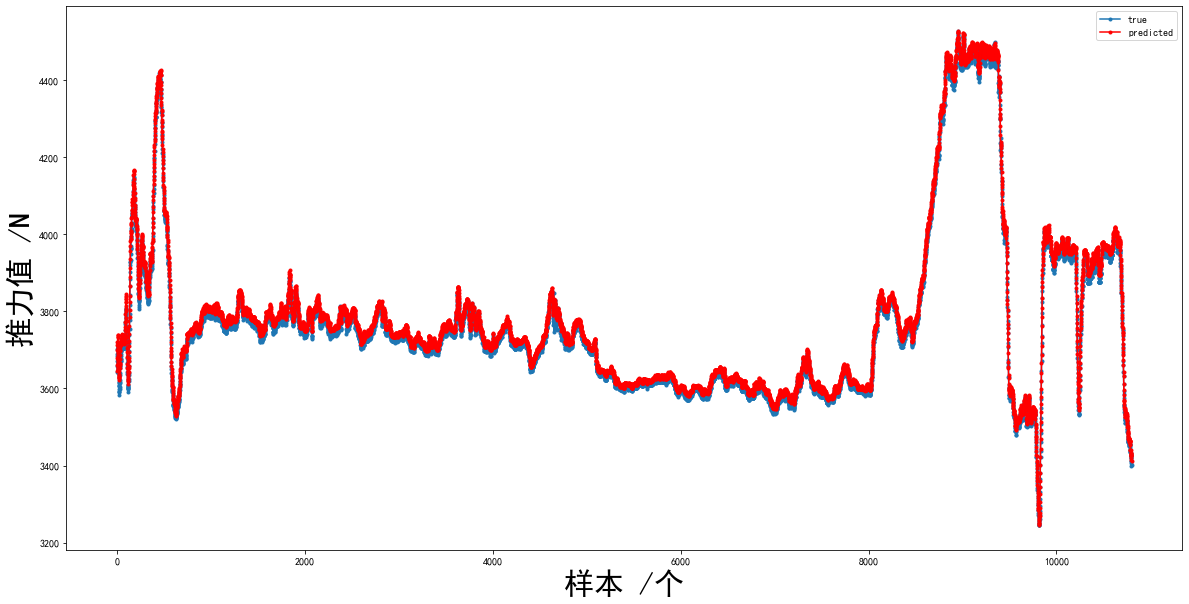

In [35]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();